# -*- coding: utf-8 -*-
__author__ = 'Gerald Schuller'
__copyright__ = 'G.S.'


"""
Simple program to use a convolutional neural network to obtain a predictive coder,
using explicit inputs to layers, to enable skip layers.
According to: https://keras.io/getting-started/functional-api-guide/
With Pytorch
For instance according to WCLMS or prediction Boosting
Gerald Schuller, November 2018.
"""

In [31]:
# Importing necessary modules.

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt         # understood this
import sys
import pickle
import librosa
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

In [32]:
# Here should load an audio file (We will not use scipy.io.wavfile). 
#Choose one file from our dataset, we already have them as a numpy array.

t = np.load('/Users/DELL/Updated_binder_enviro/all-samples/banjo/banjo_A3_very-long_forte_normal.npy')
sr = 44100    #understood that we are just taking one file and loading it
print(t)

[0. 0. 0. ... 0. 0. 0.]


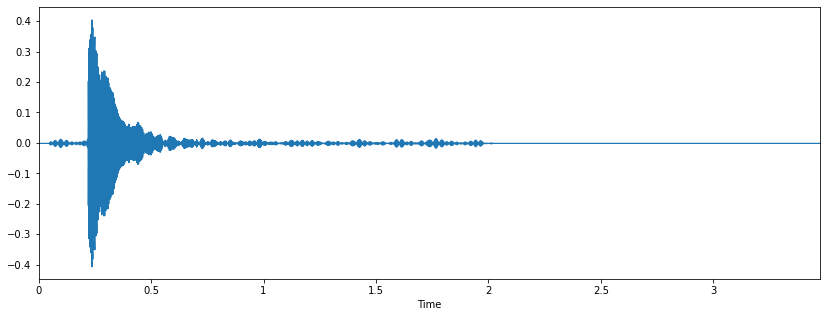

In [33]:
# Here should plot and playback the audio file.
# Plotting the original audio file

plt.figure(figsize=(14, 5))     #understood that we are just plotting the original file here
librosa.display.waveplot(t, sr=sr);

In [34]:
import IPython.display as ipd  #play back the original audio file
ipd.Audio(data=t,rate=sr,autoplay=True)      #understood that we are playing back the original file here


In [35]:
# Here is the pre-process of the audio file if needed.

print(t.shape)
a=torch.from_numpy(t)

audio=a*1.0/2**15   # He normalized the audio
audiosh=audio[:100000]                              # understood that we are making the file a little short for faster processing
X = audiosh[:99999]
Y =audiosh[1:100000]
print(X.shape)    ############ I know that we normalize when we want to make it louder or when we want the samples to be similar
                   ## i see that the starting samples are 0 0 so I guess we bill be doing matching normalization
print(Y.shape) ####### Am i getting it right?

(153216,)
torch.Size([99999])
torch.Size([99999])


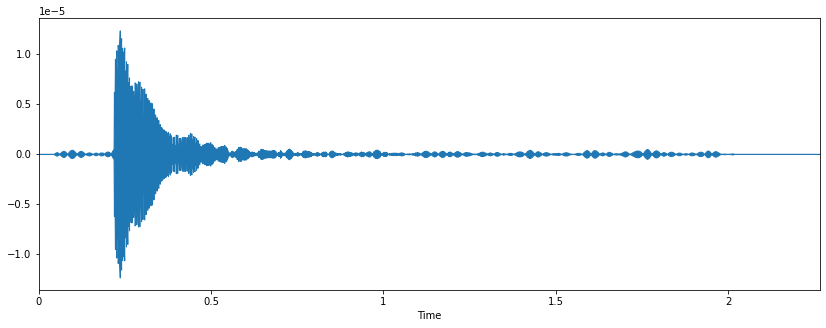

In [38]:
# Here should plot and playback the shortened audio file.
# Play back the shortened audio file
%matplotlib inline

plt.figure(figsize=(14, 5))      # understood that we are displaying and playing back the shortened audio file here
librosa.display.waveplot(X.numpy(), sr=sr)
ipd.Audio(data=X.numpy(),rate=sr,autoplay=True)

## CORRECT; BUT TAKE A LOOK AT THE AMPLITUDE OF THE AUDIO FILE. THE MAXIMUM APLITUDE IS THE ORDER OF MAGNITUE OF 1e-5.THIS IS VERY SMALL.
## WE WANT OUR DATA TO BE NORMALIZED FROM VALUES BETWEEN -1 AND 1.
## YOU NEED TO FIX THIS.

## This next part is related to me doing research on normalization

tensor([3.0137e-07, 3.0137e-07, 3.0137e-07,  ..., 3.0137e-07, 3.0137e-07,
        3.0137e-07])
torch.Size([99999])
torch.Size([99999])
[[-1.+0.j -1.+0.j -1.+0.j ... -1.+0.j -1.+0.j -1.+0.j]
 [-1.+0.j -1.+0.j -1.+0.j ... -1.+0.j -1.+0.j -1.+0.j]
 [-1.+0.j -1.+0.j -1.+0.j ... -1.+0.j -1.+0.j -1.+0.j]
 ...
 [-1.+0.j -1.+0.j -1.+0.j ... -1.+0.j -1.+0.j -1.+0.j]
 [-1.+0.j -1.+0.j -1.+0.j ... -1.+0.j -1.+0.j -1.+0.j]
 [-1.+0.j -1.+0.j -1.+0.j ... -1.+0.j -1.+0.j -1.+0.j]]


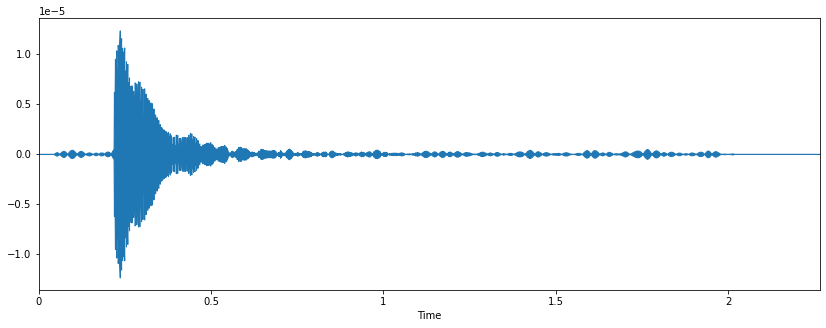

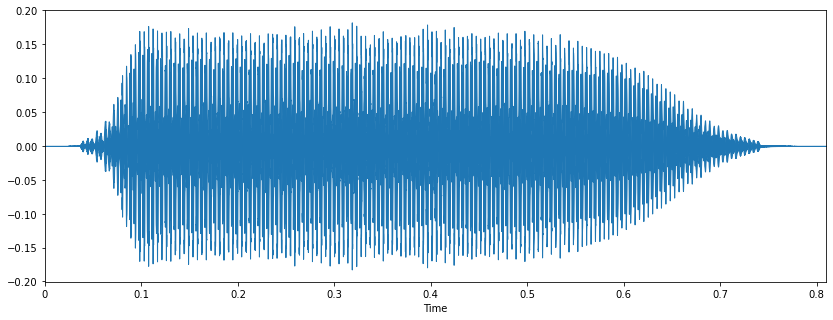

In [19]:
 
    # Subtract the mean, and scale to the interval [-1,1]
tensor_minusmean = a - a.mean()
normaudio= tensor_minusmean/tensor_minusmean.abs().max()
print(normaudio)
audiosh=normaudio[:100000]                              # understood that we are making the file a little short for faster processing
A = audiosh[:99999]
B =audiosh[1:100000]
print(A.shape)    ############ I know that we normalize when we want to make it louder or when we want the samples to be similar
                   ## i see that the starting samples are 0 0 so I guess we bill be doing matching normalization
print(B.shape)
plt.figure(figsize=(14, 5))      # understood that we are displaying and playing back the shortened audio file here
librosa.display.waveplot(X.numpy(), sr=sr,alpha=1)
ipd.Audio(data=A.numpy(),rate=sr,autoplay=True)
##################################################

f, sr = librosa.load('/Users/DELL/Updated_binder_enviro/all-samples/bass-clarinet/bass-clarinet_A2_1_forte_normal.mp3', sr = None)
normalizedy = librosa.util.normalize(f)

stft = librosa.core.stft(normalizedy, n_fft = 256, hop_length=16)
mel = librosa.feature.melspectrogram(S=stft, n_mels=32)
mellog = np.log(mel + 1e-9)
melnormalized = librosa.util.normalize(mellog)
print(melnormalized)
plt.figure(figsize=(14, 5))      # understood that we are displaying and playing back the shortened audio file here
librosa.display.waveplot(f, sr=sr,alpha=1)
#ipd.Audio(data=melnormalized,rate=sr,autoplay=True)




## The resaerch code ends here

## I am so confused about normalization. You said something about the characteristics of the audio file that we are using, I tried searchin online but I don't think I am searching the right thing. Also, I read about sklearn normalizing and standardscale and all. I am confused about that too. Should I normalize first and then convert into tensor or vice versa. 

In [39]:
L=12 #filter length        # did not understand that why do we have to take the filter length 12 only and why dilation to 1 only????
dilation=1 #Dilation: upsampling the filter impulse response, new filter length: (L-1)*dilation+1

#### So, regarding dilation,it is how much space is there in between filter blocks. I saw an animation where the guy had 
# a filter moving over the input and there are some empty blocks in the filer. That was dilation. I guess spacing between the 
# elements of the filter.


In [40]:
def format_vector2pytorch(vector):
    
    #Function to convert a vector, like a mono audio signal, into a 3-d Tensor X that Keras expects
    #Tensor X with shape (batch, signal):
    #https://discuss.pytorch.org/t/confused-about-tensor-dimensions-and-batches/4761
    
    X = np.expand_dims(vector, axis=0)  #add batch dimension (here only 1 batch)
    X = np.expand_dims(X, axis=0)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)      #understood that we are converting the test and target data to the kind of input Conv1d expects
    return X


In [41]:
# Converting the input to the type of inputs that a Convolutional layer expects
X=format_vector2pytorch(audiosh[:-((L-1)*dilation+1)])      #remove last samples 
Y=format_vector2pytorch(audiosh[1:]) #r

print("Input X.shape=", X.shape )
print("Target Y.shape=", Y.shape)   #understood that we are calling the functions to convert the input 

   ### I did not understood this L-1 formula
    
## # also little confusion. I removed the last sample in the code above, and then I though we can just call 
# format_vector2pytorch and convert our input for convolutional here then why this calculation inside? wht not pass X and Y
# defined above directly X = audiosh[:99999]
# Y =audiosh[1:100000] these.


Input X.shape= torch.Size([1, 1, 99988])
Target Y.shape= torch.Size([1, 1, 99999])


In [42]:
# Here should be the definition of the PyTorch model
class MyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        # define network layers
        self.layer1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=L, stride=1, dilation=dilation, padding=dilation*(L-1), bias=False)
        
        # did not understand why padding is to this specific specifications why not 1 or 2? or anything else
    def forward(self, x):
        # define forward pass          
        x = self.layer1(x)
        return x
print("Generate Model:")
model = MyNetwork()
print(model)
######################################################################
## padding is used to retain the same dimesnion as the input
# I just know how to calculate lout and cout. but formula for cout is a bit confusing
# The entire shape, I don't think I understod that

Generate Model:
MyNetwork(
  (layer1): Conv1d(1, 1, kernel_size=(12,), stride=(1,), padding=(11,), bias=False)
)


In [43]:
# Here should be the definition of the loss function and the optimizer
n_epochs = 1000
learning_rate = 1e-4
print("Def. loss function:")   # i studied the documentation of MSELoss did not understand why do I have to chnange reduction=sum because it was giving error otherwise
loss_fn = nn.MSELoss()#size_average=False,reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
###### The code works without it as well
    

Def. loss function:


In [25]:
# Here should be the training of the model

for epoch in range(1000):
    Ypred=model(X)
    loss=loss_fn(Ypred, Y)    #understood that we are training the model calling predictions with Ypred then computing
    if epoch%100==0:        #gradient with loss.backward and before it setting the gradient to zero for every cycle
        print(epoch, loss.item())  #and using optimizer.step to update the values
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


0 869.521240234375
100 868.4913940429688
200 867.4622802734375
300 866.4341430664062
400 865.4071044921875
500 864.3809814453125
600 863.355712890625
700 862.3313598632812
800 861.3082275390625
900 860.2861328125


In [26]:
# Here should be the predictions after the model is trained
predictions=model(X)  #understood that we are calling predictions here and checking its shape to see teh dimensions
print(predictions)
print(predictions.shape)

tensor([[[-6.4538e-08, -6.2197e-08, -1.4185e-07,  ...,  1.9486e-05,
          -2.2025e-05,  1.0917e-05]]], grad_fn=<SqueezeBackward1>)
torch.Size([1, 1, 99999])


In [27]:
# Here should be the computation of the prediction errors

#mean squared predicton error:

err= sum((predictions-Y[0])**2)/max(Y.shape)      # did not understand this part
print("mean squared prediction error=", err)
## ## HERE YOU SHOULD CALCULATE THE MEAN SQUARED ERROR BETWEEN THE PREDICTIOSN AND THE TARGET. REMEMBER THAT THE DATA TYPE NOW IS A PYTORCH TENSOR.
## this I will do after we clear up the normalizing part

mean squared prediction error= tensor([[1.3389e-18, 1.3218e-18, 1.9645e-18,  ..., 1.6697e-14, 1.4228e-14,
         1.1985e-13]], grad_fn=<DivBackward0>)


In [28]:
# Here should be the plots of the results


In [29]:
# Here you can save the model
torch.save({'epoch': epoch,        #did not understand this part
       'model_state_dict': model.state_dict(),
       'optimizer_state_dict': optimizer.state_dict()}, "linpredweights.torch")

In [30]:
#mean signal power:
sigpow=sum(X[0,0,:]**2)/max(X.shape)
print("mean signal power=", sigpow)
print("Signal to Error Power Ratio:", sigpow/err)
    
ww = model.state_dict()   #read obtained weights
print("ww=", ww)
#weight format for Conv1d:
#[0: filter weights, 1: bias for first layer]
 #weight: filters of shape: out_channelsÃ— in_channelsgroupsÃ— kW
weights=ww['layer1.0.weight'][0,0,:]
    
    
print("weights= ", weights)
 #print("Predictions[0,0,:]= ", predictions[0,0,:])
    
#print("Y=",Y)
 #convert to numpy:
    #https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2
    #plt.plot(np.array(Y[0,0,:]))
    #plt.show()
plt.plot(np.array(Y[0,0,:]))
plt.plot(predictions.detach().numpy()[0,0,:])
plt.legend(('Original','Predicted'))
plt.title('The Original and Predicted Signal')
plt.xlabel('Sample')
plt.figure()
plt.plot(np.array(Y[0,0,:]))
plt.plot(predictions.detach().numpy()[0,0,:]-np.array(Y[0,0,:]))
plt.legend(('Original','Prediction Error'))
plt.title('The Original and Prediction Error')
plt.xlabel('Sample')
plt.figure()
plt.plot(np.array(weights))
plt.title('The Weights')
plt.show()

mean signal power= tensor(8.6125e-13)
Signal to Error Power Ratio: tensor([[       inf,        inf,        inf,  ..., 4.6597e+10, 4.5171e+10,
         2.0418e+10]], grad_fn=<DivBackward0>)
ww= OrderedDict([('layer1.weight', tensor([[[-0.0007,  0.1864,  0.1168,  0.1130, -0.1009,  0.1364,  0.1623,
          -0.1875, -0.0470, -0.0264,  0.0160, -0.2518]]]))])


KeyError: 'layer1.0.weight'

## Prof Schuller's Code

In [91]:


L=12 #filter length
dilation=1 #Dilation: upsampling the filter impulse response, new filter length: (L-1)*dilation+1

In [27]:
def format_vector2pytorch(vector):
    
    #Function to convert a vector, like a mono audio signal, into a 3-d Tensor X that Keras expects
    #Tensor X with shape (batch, signal):
    #https://discuss.pytorch.org/t/confused-about-tensor-dimensions-and-batches/4761
    
    X = np.expand_dims(vector, axis=0)  #add batch dimension (here only 1 batch)
    X = np.expand_dims(X, axis=0)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    return X


C:\Users\DELL\anaconda3\envs\BRP2\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


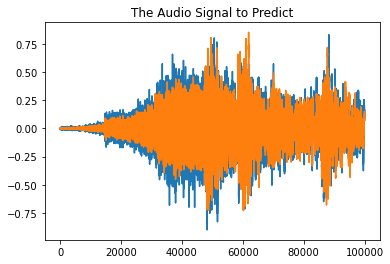

Generate Model:
Input X.shape= torch.Size([1, 1, 99988, 2])
Target Y.shape= torch.Size([1, 1, 99999, 2])
Generate Model:
Def. loss function:


C:\Users\DELL\anaconda3\envs\BRP2\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


NotImplementedError: 

In [93]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # Define the model. 
        
        self.layer1=nn.Sequential(nn.Conv1d(in_channels=1, out_channels=1, kernel_size=L, stride=1, dilation=dilation, padding=dilation*(L-1), bias=False))
            
      #https://pytorch.org/docs/stable/nn.html#conv1d  
      # Generate a convolutional neural network model, 1 layer, no bias, linear activation function 
      # returns: Trainable object
      #concatenate data:
      #https://discuss.pytorch.org/t/concatenate-layer-output-with-additional-input-data/20462
      #input of layer: x, output of layer: out
        
        def forward(self, x):
            out = self.layer1(x)
            return out
    

if __name__ == '__main__':
    
    #Example to find prediction coefficients to minimize the mean absolute error using Python Keras
    #and 1 Convolutional layer as a predictor.
    
    #Input mono audio signal X:
    
    samplerate, audio = wav.read("trywav.wav")
    
    #samplerate, audio = wav.read("trywav.wav")
    #samplerate, audio = wav.read("fspeech.wav")
    #samplerate, audio = wav.read("WCLMSprederror.wav")
    
    audio=audio*1.0/2**15          #normalize
    
    #audio=audio*1.0/np.max(np.abs(audio)) #normalize
    
    audiosh=audio[:100000]             #shorten the signal for faster optimization,
    
    #audiosh=audio[46750:47750]
    
    plt.plot(audiosh)
    plt.title("The Audio Signal to Predict")
    plt.show()
    
    X=format_vector2pytorch(audiosh[:-((L-1)*dilation+1)])      #remove last samples 
    Y=format_vector2pytorch(audiosh[1:]) #remove first sample, for the signal to predict, 1 sample in the future
    
    print("Generate Model:")
    print("Input X.shape=", X.shape )
    print("Target Y.shape=", Y.shape)

    print("Generate Model:")
    #model = generate_model()     # Compile an neural net
    model = ConvNet()#.to('cpu')
    print("Def. loss function:")
    loss_fn = nn.MSELoss(size_average=False)
    #learning_rate = 1e-4
    optimizer = torch.optim.Adam(model.parameters())#, lr=learning_rate)
    
    
    for epoch in range(6000):
        Ypred=model(X)
        loss=loss_fn(Ypred, Y)
        if epoch%100==0:
            print(epoch, loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    torch.save({'epoch': epoch,
       'model_state_dict': model.state_dict(),
       'optimizer_state_dict': optimizer.state_dict()}, "linpredweights.torch")
    
    #Processing full length signal:
    X=format_vector2pytorch(audio[:-((L-1)*dilation+1)])  #remove last samples 
    Y=format_vector2pytorch(audio[1:]) #remove first sample
    predictions=model(X) # Make Predictions based on the obtained weights, on short audio
    #mean squared predicton error:
    err= sum((predictions[0,0,:]-Y[0,0,:])**2)/max(Y.shape)
    print("mean squared prediction error=", err)
    #mean signal power:
    sigpow=sum(X[0,0,:]**2)/max(X.shape)
    print("mean signal power=", sigpow)
    print("Signal to Error Power Ratio:", sigpow/err)
    
    ww = model.state_dict()   #read obtained weights
    print("ww=", ww)
    #weight format for Conv1d:
    #[0: filter weights, 1: bias for first layer]
    #weight: filters of shape: out_channelsÃ— in_channelsgroupsÃ— kW
    weights=ww['layer1.0.weight'][0,0,:]
    
    
    print("weights= ", weights)
    #print("Predictions[0,0,:]= ", predictions[0,0,:])
    
    #print("Y=",Y)
    #convert to numpy:
    #https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2
    #plt.plot(np.array(Y[0,0,:]))
    #plt.show()
    plt.plot(np.array(Y[0,0,:]))
    plt.plot(predictions.detach().numpy()[0,0,:])
    plt.legend(('Original','Predicted'))
    plt.title('The Original and Predicted Signal')
    plt.xlabel('Sample')
    plt.figure()
    plt.plot(np.array(Y[0,0,:]))
    plt.plot(predictions.detach().numpy()[0,0,:]-np.array(Y[0,0,:]))
    plt.legend(('Original','Prediction Error'))
    plt.title('The Original and Prediction Error')
    plt.xlabel('Sample')
    plt.figure()
    plt.plot(np.array(weights))
    plt.title('The Weights')
    plt.show()